# Generative Adversarial Networks
We are interested in learning the distribution of a dataset so that we can create novel samples from it. For instance, given a dataset of images, we'd like to generate a new image that looks similar to ones from the dataset. This is known as generative learning.

One idea to accomplish this is to have a neural network that takes in a random noise vector and maps it a corresponding sample. We will call this the "generator". The difficulty arises in how to train this network. We would like a differentiable measure of how much our sample "looks" like it was from the original dataset, and use this as a loss to train our generator. In ["Generative Adversarial Nets"](https://arxiv.org/pdf/1406.2661.pdf) (GANs) Goodfellow et al. propose that this measure come from another neural network which is trained to distinguish between samples from our generator and the dataset. We call this the "discriminator". Specifically, we treat this as a two player game with the objective

$$ \min_G \max_D \mathbb{E}_{x\sim p_\text{data}(x)} [\log(D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log(1 - D(G(z)))] $$

where $G(z)$ is our generator, $D(x)$ is our discriminator, $p_\text{data}$ is our data distribution, and $p_z$ is our noise distribution. Intuitively, the theoretical optimum of this game is where our generator is matching the distribution of the data perfectly, so our discriminator can only randomly guess. 

In practice, this problem [lacks nice properties](https://arxiv.org/pdf/2002.09124.pdf) and is challenging to optimize. The simplest approach is to alternate taking gradient steps for each player. Empirically, Radford et al. show in [their paper](https://arxiv.org/pdf/1511.06434.pdf) properties for deep convolutional neural networks that make this optimization more stable. They remove fully connected and pooling layers, and leave only (fractionally-)strided convolutions. For the generator, the noise vector is first linearly projected into a feature map followed by repeated fractionally-strided convolutions that take us to the final image. The discriminator is the reverse of this architecture: strided convolutions map to a final feature map from which a binary linear classification is performed. All of the layers, except the discriminator input layer and the generator output layer, have [batch normalizations](https://arxiv.org/abs/1502.03167). They call their architecture "Deep Convolutional Generative Adversarial Networks" or DCGANs. We can then train the networks with [Adam](https://arxiv.org/pdf/1412.6980.pdf) with tuned parameters.

## Overview

We begin by examining the "dining room" class from the [LSUN dataset](https://www.yf.io/p/lsun). We then implement our DCGAN and perform limited training. We then examine samples from the generator and look at linear interpolations between samples.

## A small experiment

The dataset consists of 657,571 pictures of dining rooms and is roughly 13GB.

To download the data either go to the [LSUN repository](https://github.com/fyu/lsun) and run the download script (```python3 download.py -c dining_room```) or download the zip directly [here](http://dl.yf.io/lsun/scenes/dining_room_train_lmdb.zip). Unzip and place the resulting training data in a new directory called "data". The final directory should look like this:
* data/dining_room_train_lmdb/data.mdb  
* data/dining_room_train_lmdb/lock.mdb

Place the "data" directory in the same one as this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, CenterCrop, ToTensor

Now we will use torchvision to read in the data. We will apply a few transformations to the images. First, we will resize them so that the minimum length side is $64$ pixels. We will then do a center crop to get a $64 \times 64$ image. The pixel values are represented as floats in the range $[0,1]$. We will stretch this so it is centered at zero: $[-1, 1]$. This last step was done since the final activation of the generator is a "tanh", which is not a necessary design choice.

In [2]:
# Take image with values in [0,1] and stretch it to [-1,1]
class CenterAtZero(object):
    def __call__(self, image):
        return 2*image - 1

transform = torchvision.transforms.Compose([
    Resize(64),
    CenterCrop(64),
    ToTensor(),
    CenterAtZero()
])

dataset = torchvision.datasets.LSUN('./data', classes=['dining_room_train'], transform=transform)

batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=6)

Let's examine some images from the dataset.

There are 657571 images in the dataset.


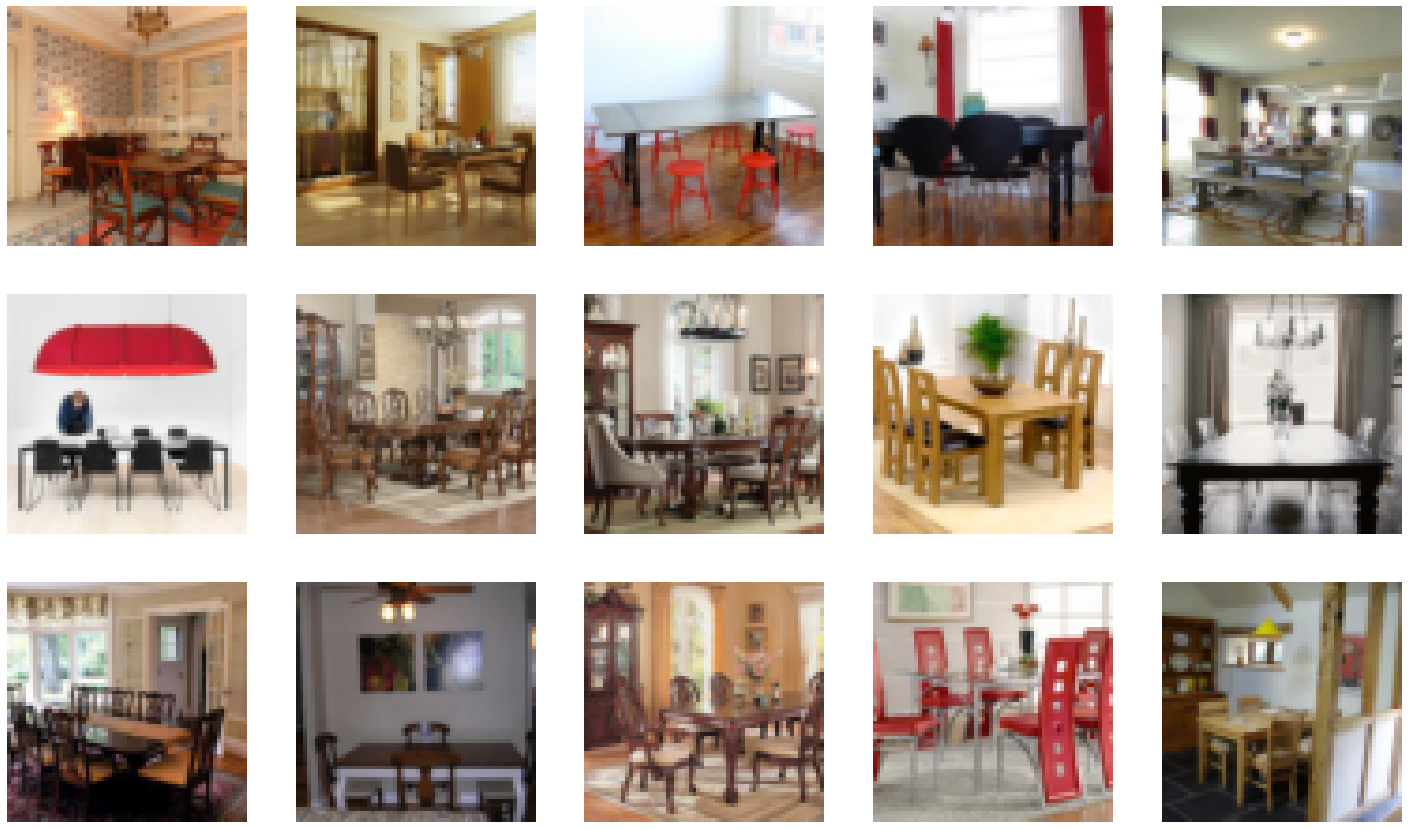

In [3]:
W = 5
H = 3
fig, axes = plt.subplots(H, W)
for row in axes:
    for ax in row:
        x = dataset[np.random.randint(len(dataset))][0]
        ax.imshow((x.permute(1,2,0).numpy()+1)/2)
        ax.axis('off')
fig.set_figheight(5*H)
fig.set_figwidth(5*W)

print('There are ' + str(len(dataset)) + ' images in the dataset.')

Let's implement the generator as we described above. The parameters follow the DCGAN paper, including the intialization of all weights to be from a normal distribution with mean zero and standard deviation $0.02$. Because we do a batch normalization between all layers, we remove the bias term because it is redundant. Our noise sample will be a vector of length "latent_dim" with each element independently sampled from a uniform distribution on $[-1, 1]$.

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.proj = nn.Linear(latent_dim, 1024*4*4, bias=False)
        self.deconv1 = nn.ConvTranspose2d(1024, 512, (4,4), padding=1, stride=2, bias=False)
        self.deconv2 = nn.ConvTranspose2d(512, 256, (4,4), padding=1, stride=2, bias=False)
        self.deconv3 = nn.ConvTranspose2d(256, 128, (4,4), padding=1, stride=2, bias=False)
        self.deconv4 = nn.ConvTranspose2d(128, 3, (4,4), padding=1, stride=2, bias=False)
        self.bn0 = nn.BatchNorm2d(1024)
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if type(m) == nn.ConvTranspose2d or \
           type(m) == nn.Conv2d or \
           type(m) == nn.Linear:
            m.weight.data.normal_(mean=0.0, std=0.02)
        
    def forward(self, x):
        x = self.proj(x)
        x = self.bn0(x.view(-1, 1024, 4, 4))
        x = torch.relu(self.bn1(self.deconv1(x)))
        x = torch.relu(self.bn2(self.deconv2(x)))
        x = torch.relu(self.bn3(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))

        return x

For the discriminator the number of channels are halved compared to the generator. This was to save some computation and it seemed adequate for [this tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, (4,4), padding=1, stride=2, bias=False)
        self.conv2 = nn.Conv2d(64, 128, (4,4), padding=1, stride=2, bias=False)
        self.conv3 = nn.Conv2d(128, 256, (4,4), padding=1, stride=2, bias=False)
        self.conv4 = nn.Conv2d(256, 512, (4,4), padding=1, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.flatten = nn.Flatten()
        self.classify = nn.Linear(512*4*4, 1)
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if type(m) == nn.Conv2d or type(m) == nn.Linear:
            m.weight.data.normal_(mean=0.0, std=0.02)
        
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = self.flatten(x)
        x = torch.sigmoid(self.classify(x))
        return x

Let's train!

The original GAN paper suggests training the generator with the objective 

$$\max_G \mathbb{E}_{p_z(z)} [\log D(G(z))]$$ 

instead of the original objective, to have stronger gradients early in training. The DCGAN paper suggests a learning rate of $0.0002$ and $\beta_1 = 0.5$ for Adam.

The generator has 12658432 parameters.
The discriminator has 2765697 parameters.
Iteration 0 : Loss 1.7346737
Iteration 10 : Loss 1.1306778
Iteration 20 : Loss 0.88443744
Iteration 30 : Loss 0.37667
Iteration 40 : Loss 2.8782504
Iteration 50 : Loss 0.6768412
Iteration 60 : Loss 1.0794597
Iteration 70 : Loss 0.83154154
Iteration 80 : Loss 1.1420946
Iteration 90 : Loss 0.6473948
Iteration 100 : Loss 1.2103287
Iteration 110 : Loss 1.095336
Iteration 120 : Loss 2.5989802
Iteration 130 : Loss 0.3671804
Iteration 140 : Loss 0.9098989
Iteration 150 : Loss 1.1965318
Iteration 160 : Loss 1.0556617
Iteration 170 : Loss 1.1686466
Iteration 180 : Loss 0.7679281
Iteration 190 : Loss 1.453058
Iteration 200 : Loss 0.9837651
Iteration 210 : Loss 0.9303593
Iteration 220 : Loss 1.3915803
Iteration 230 : Loss 1.010824
Iteration 240 : Loss 1.008894
Iteration 250 : Loss 1.5230498
Iteration 260 : Loss 1.1417716
Iteration 270 : Loss 1.7865837
Iteration 280 : Loss 0.8381203
Iteration 290 : Loss 0.8905034
Iter

Iteration 2560 : Loss 1.0362322
Iteration 2570 : Loss 1.0372214
Iteration 2580 : Loss 0.74676263
Iteration 2590 : Loss 0.9494705
Iteration 2600 : Loss 1.2781944
Iteration 2610 : Loss 1.0202405
Iteration 2620 : Loss 1.0937997
Iteration 2630 : Loss 1.039006
Iteration 2640 : Loss 1.1574349
Iteration 2650 : Loss 0.92992514
Iteration 2660 : Loss 0.77217203
Iteration 2670 : Loss 1.0378907
Iteration 2680 : Loss 0.94309807
Iteration 2690 : Loss 0.88217425
Iteration 2700 : Loss 0.9350941
Iteration 2710 : Loss 0.8021916
Iteration 2720 : Loss 0.98798525
Iteration 2730 : Loss 0.84095764
Iteration 2740 : Loss 1.3012998
Iteration 2750 : Loss 0.6090337
Iteration 2760 : Loss 0.870631
Iteration 2770 : Loss 0.78385794
Iteration 2780 : Loss 0.87833196
Iteration 2790 : Loss 0.80205274
Iteration 2800 : Loss 0.8663445
Iteration 2810 : Loss 0.947834
Iteration 2820 : Loss 0.8898139
Iteration 2830 : Loss 1.2872515
Iteration 2840 : Loss 1.1285307
Iteration 2850 : Loss 1.0701361
Iteration 2860 : Loss 1.3916698
I

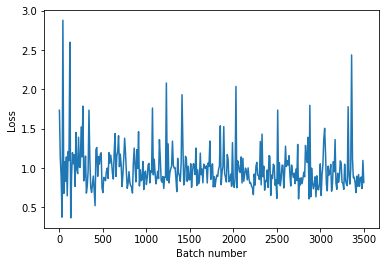

In [144]:
%%time

latent_dim = 100
generator = Generator(latent_dim=latent_dim)
discriminator = Discriminator()

### Taken from the PyTorch forums
num_params_g = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_d = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
###
print('The generator has ' + str(num_params_g) + ' parameters.')
print('The discriminator has ' + str(num_params_d) + ' parameters.')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))
n_epochs = 1
losses = []
iterations = []
batch_num = 0

train = True # Whether or not we should train the network, or just load it

# Train the network
if train:
    for epoch in range(1,n_epochs+1):
        for i_batch, sampled_batch in enumerate(dataloader):    
            # Sample
            images = sampled_batch[0].to(device)
            bsize = images.size(0)
            
            # Update Discriminator
            d_loss = -(torch.log(discriminator(images)) + \
                       torch.log(1 - discriminator(generator(2*torch.rand(bsize, latent_dim, device=device)-1)))).mean()
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            # Update Generator
            g_loss = -(torch.log(discriminator(generator(2*torch.rand(bsize, latent_dim, device=device)-1)))).mean()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # Log
            if batch_num % 10 == 0:
                with torch.no_grad():
                    losses.append(d_loss.cpu().numpy())
                    iterations.append(batch_num)
                    print('Iteration ' + str(batch_num) + ' : Loss ' + str(d_loss.cpu().numpy()))
            batch_num += 1
            
            # Stop training prematurely, as this is only a small experiment
            if i_batch == 3500:
                break

    torch.save(generator.state_dict(), 'generator.pt')
    torch.save(discriminator.state_dict(), 'discriminator.pt')

    plt.plot(iterations, losses)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    
# Load the network
else:
    generator.load_state_dict(torch.load('generator.pt'))
    discriminator.load_state_dict(torch.load('discriminator.pt'))

Let's examine some samples from generator and compare them to samples from the dataset.

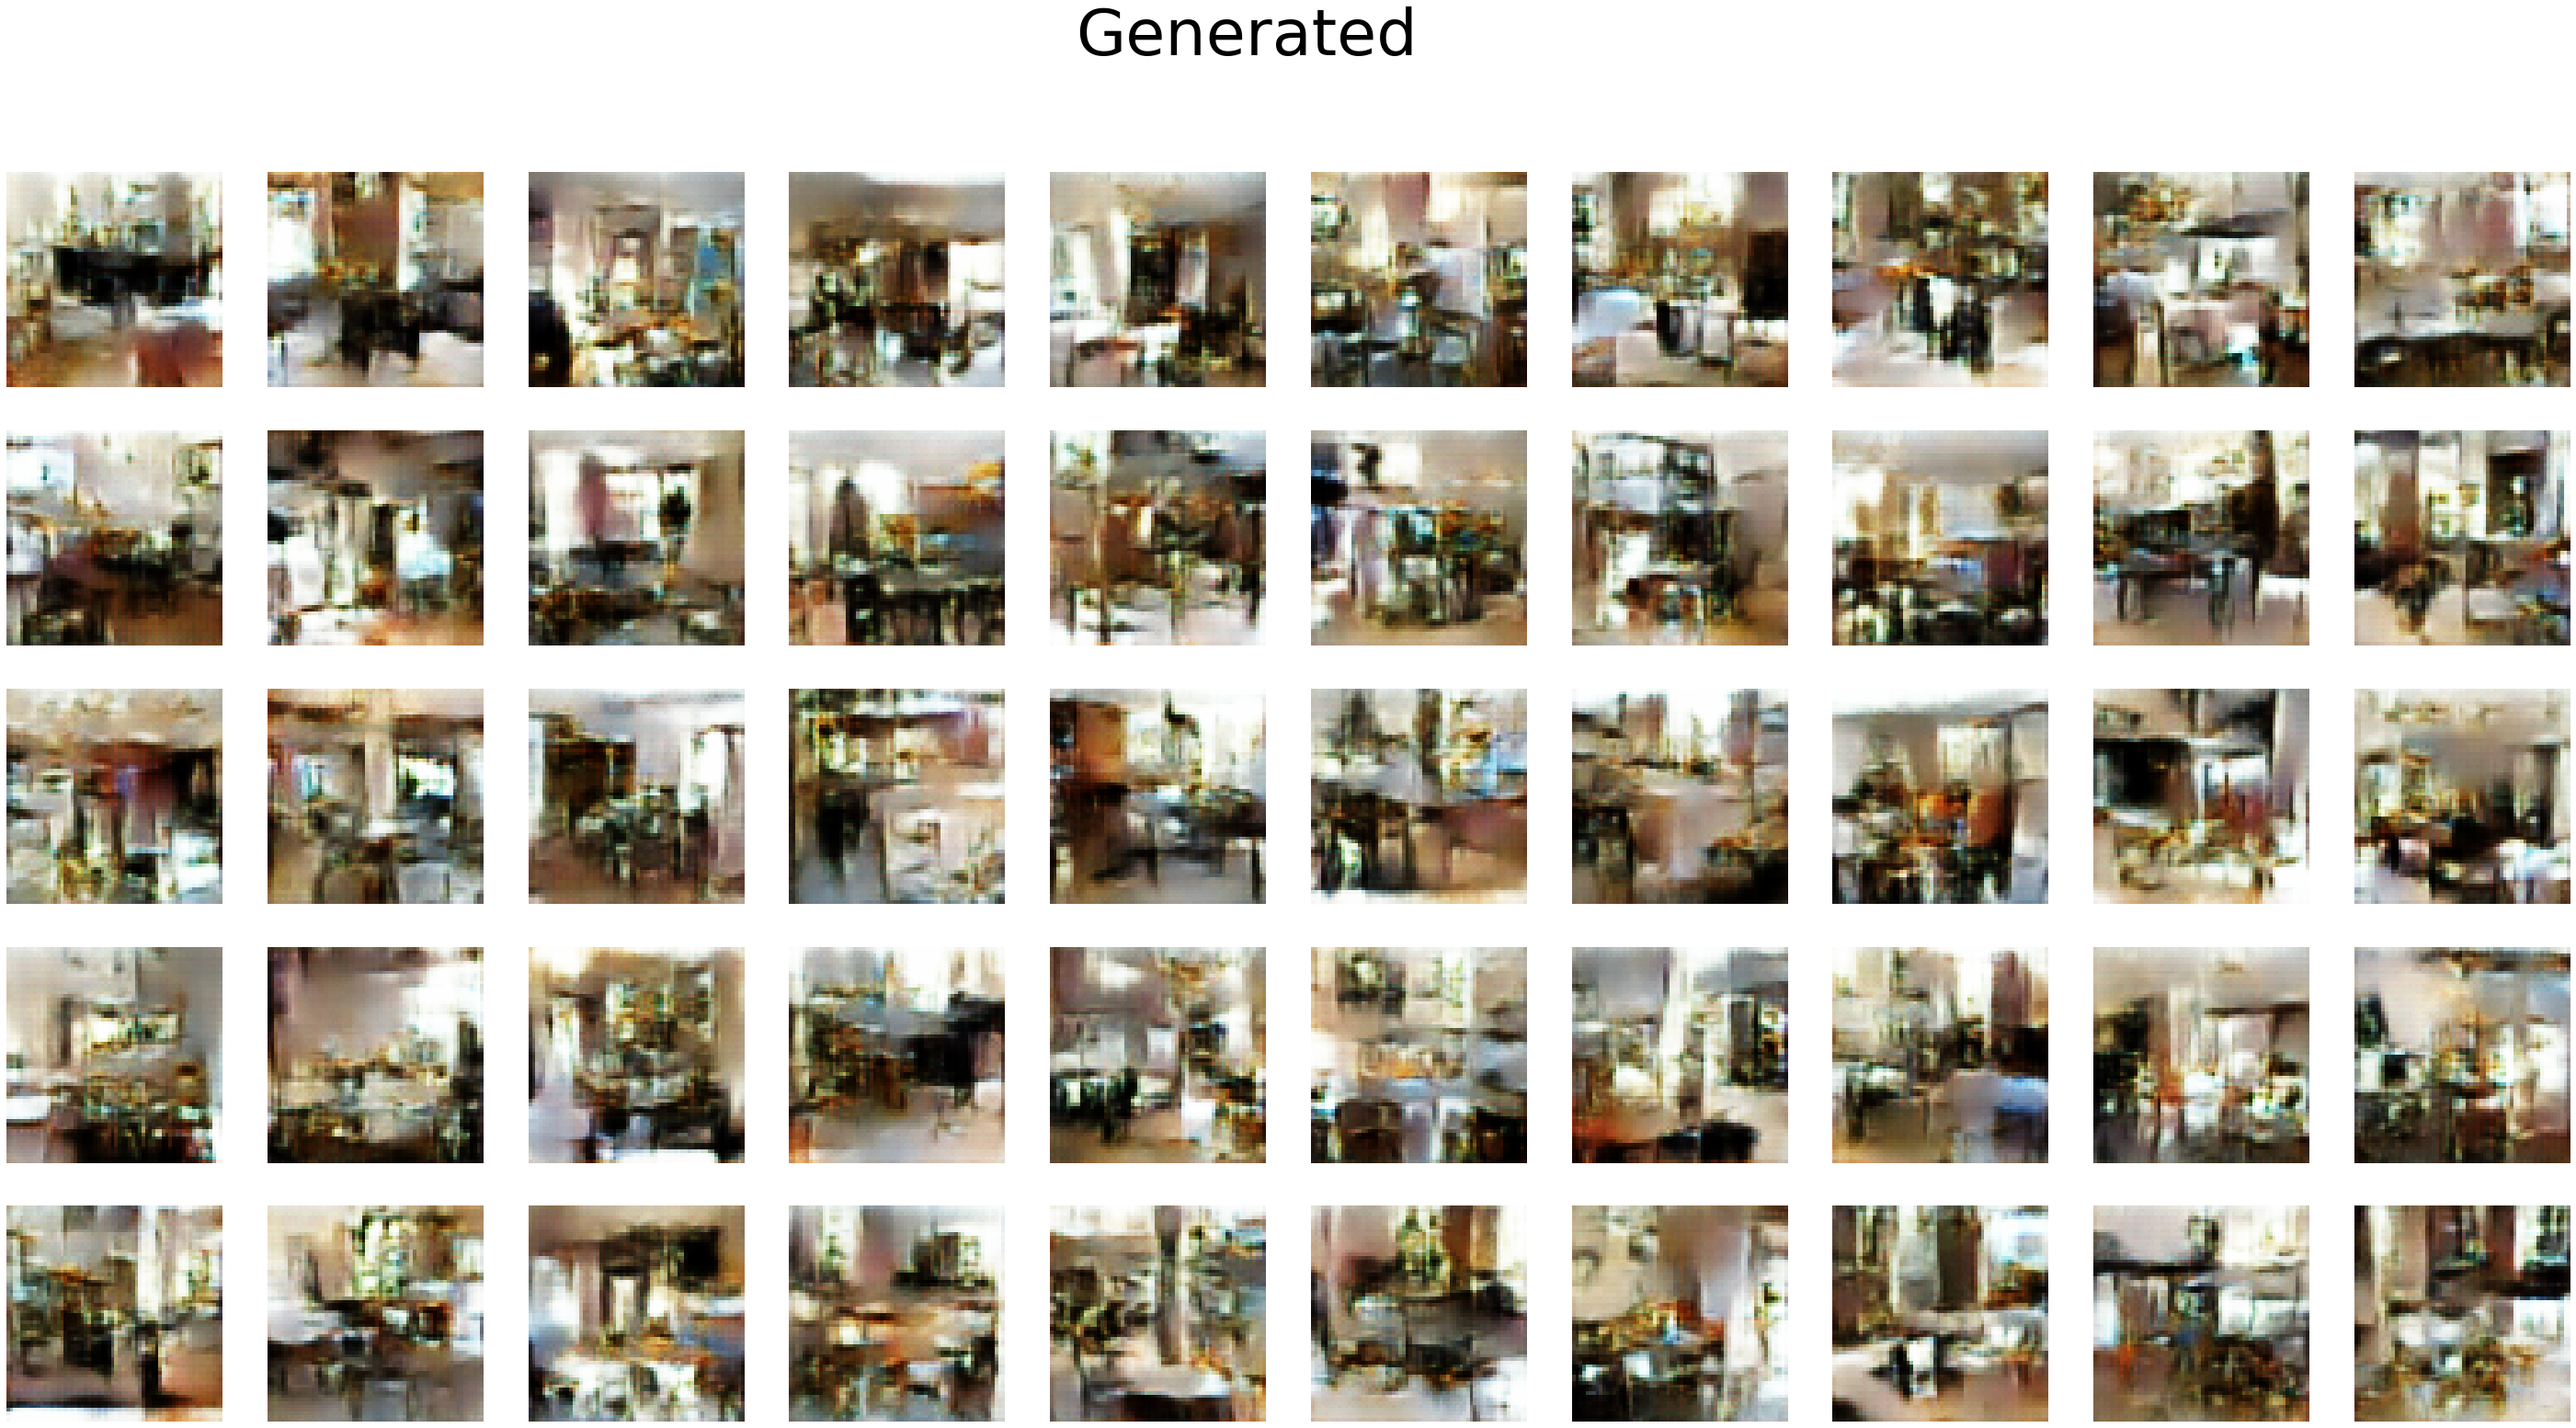

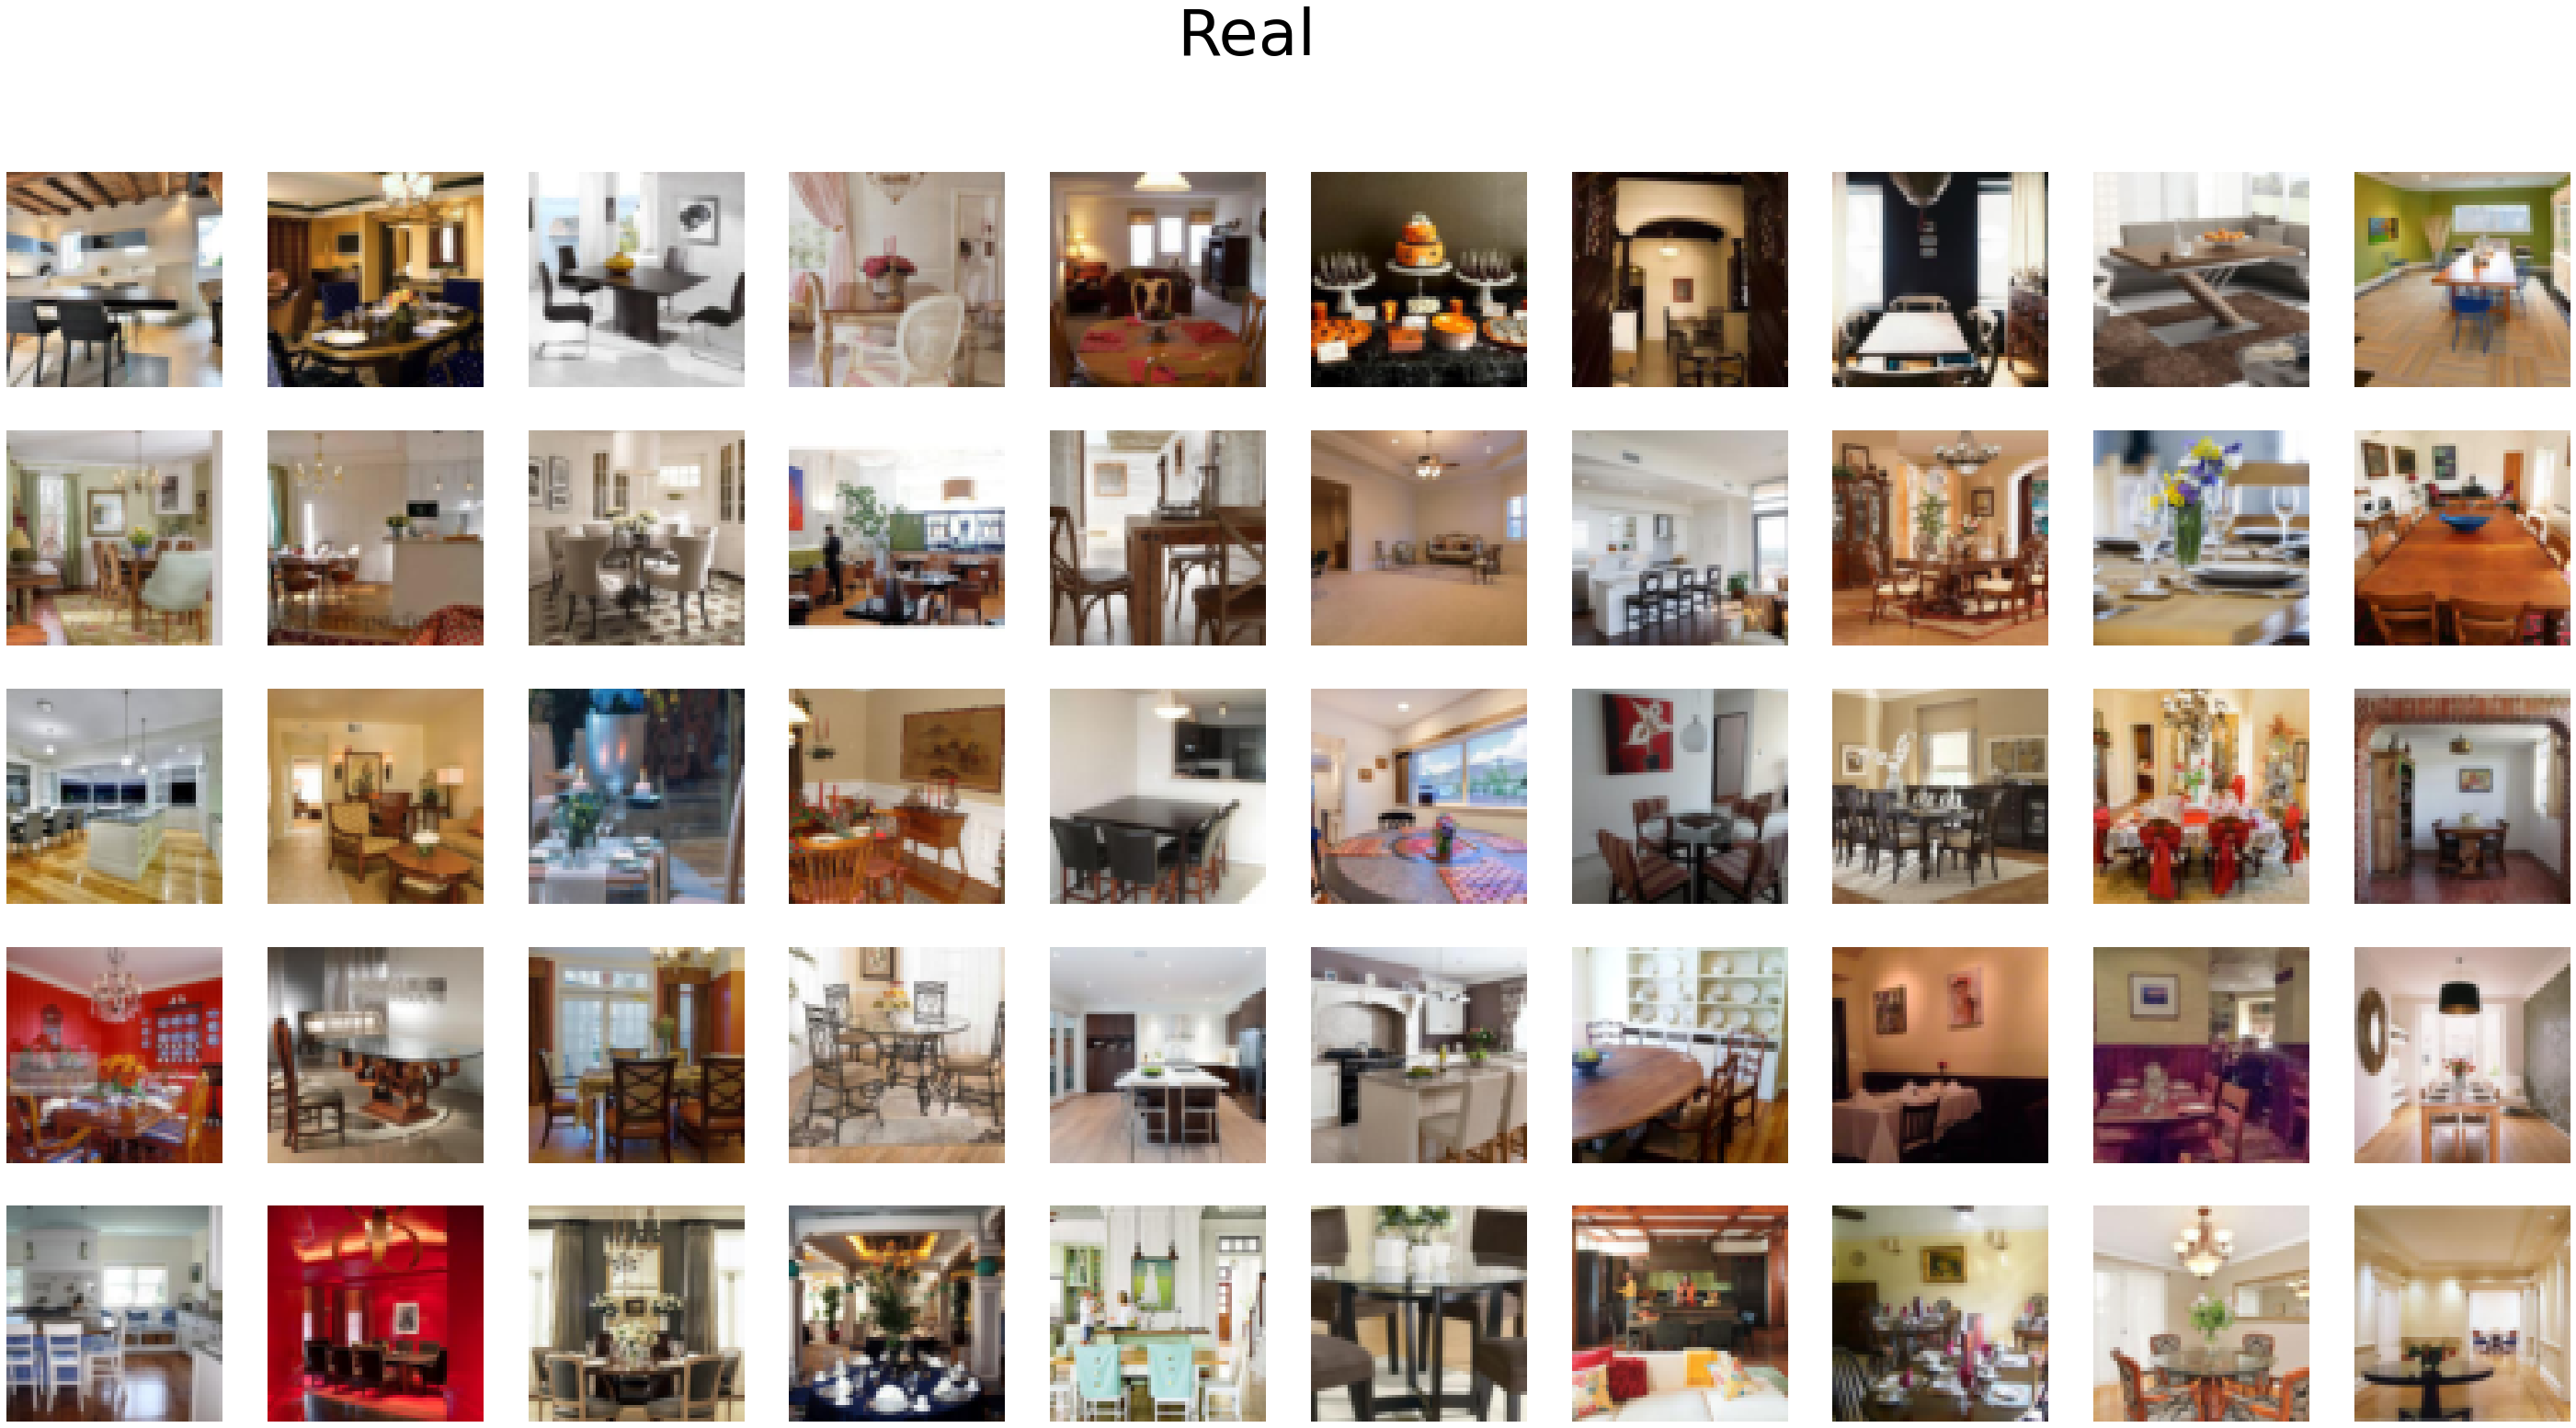

In [145]:
W = 10
H = 5
fig, axes = plt.subplots(H, W)
fig.suptitle('Generated', fontsize=70)
for row in axes:
    for ax in row:
        x = generator(2*torch.rand(1, latent_dim).to(device)-1).detach().cpu()[0]
        ax.imshow((x.permute(1,2,0).numpy()+1)/2)
        ax.axis('off')
fig.set_figheight(5*H)
fig.set_figwidth(5*W)

fig, axes = plt.subplots(H, W)
fig.suptitle('Real', fontsize=70)
for row in axes:
    for ax in row:
        x = dataset[np.random.randint(len(dataset))][0]
        ax.imshow((x.permute(1,2,0).numpy()+1)/2)
        ax.axis('off')
fig.set_figheight(5*H)
fig.set_figwidth(5*W)

Not bad! The generator is producing parts of chairs and tables, and has learned to place window and chandelier-like light sources. The box shape of the room is also apparent in some samples. Presumably, more training will result in higher quality generated images.

To see how our network is using the noise vector, we can sample two noise vectors, do a linear interpolation between them, and feed it into the generator. Our interpolation will take place from left to right across a single row in the figure below.

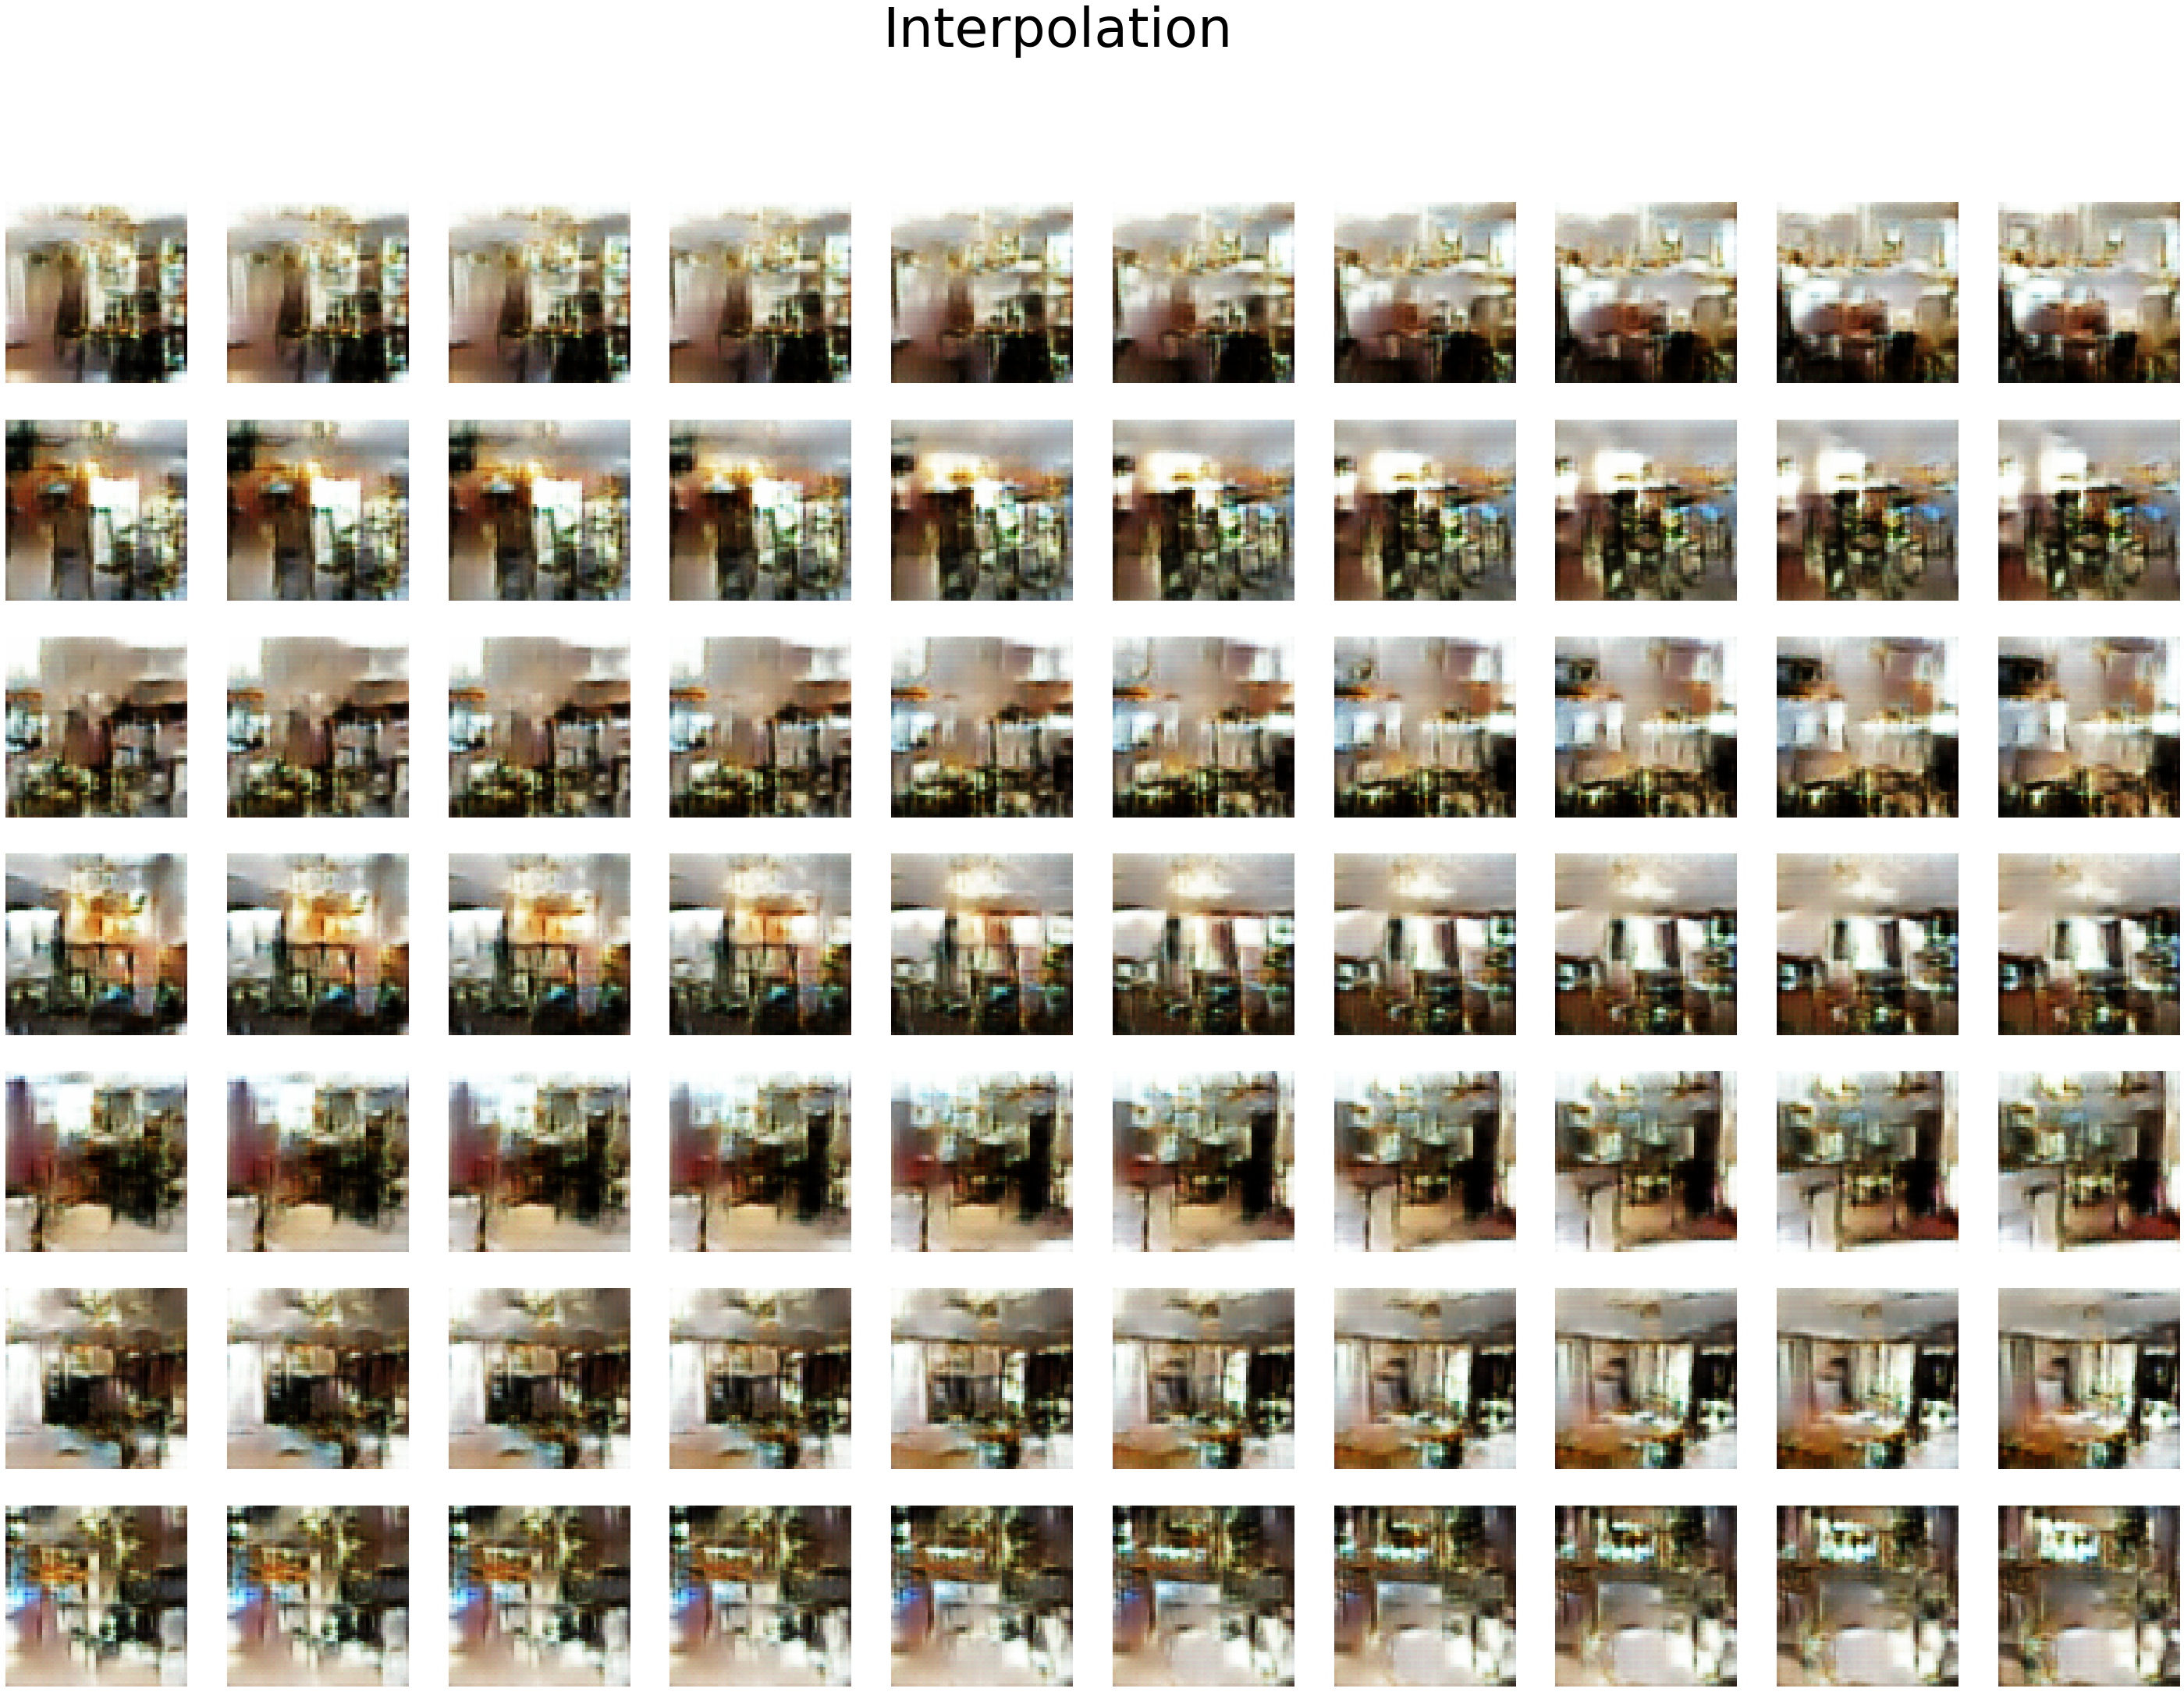

In [146]:
W = 10
H = 7
fig, axes = plt.subplots(H, W)
fig.suptitle('Interpolation', fontsize=70)
for row in axes:
    noiseLeft = 2*torch.rand(1, latent_dim).to(device)-1
    noiseRight = 2*torch.rand(1, latent_dim).to(device)-1
    for t, ax in enumerate(row):
        ratio = t/(len(row)-1)
        x = generator((1-ratio)*noiseLeft + ratio*noiseRight).detach().cpu()[0]
        ax.imshow((x.permute(1,2,0).numpy()+1)/2)
        ax.axis('off')
fig.set_figheight(5*H)
fig.set_figwidth(5*W)

In some of the samples, the change in pose between the two samples is apparant. The smooth transition also suggests that the network is not simply trying to memorize samples from the data, but is producing an interpretation of the latent space.

## Conclusion

We reviewed generative adversarial networks and examined the LSUN dining room dataset. We then trained a DCGAN and observed interesting samples and interpolations between samples from the generator.